<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/RNNs/Sequence%20Batching/Simple/Name2Lang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/RNN/")
!ls

sample_data
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

## Setting Up Dependencies

In [2]:
import torch
import numpy as np
from io import open
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import os, string, random, time, math
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [3]:
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device_gpu)

cuda:0


## Dataset

In [4]:
languages = []
data = []
X = []
Y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        Y.append(lang)
        data.append((name, lang))

In [5]:
n_languages = len(languages)
print(type(languages))
print(type(data))
print("Number of Languages : ",n_languages)
print(languages)

<class 'list'>
<class 'list'>
Number of Languages :  18
['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [6]:
for x,y in data[0:10]:
  print("Name is : ", x, " and Language is : ", y)

Name is :  Abreu  and Language is :  Portuguese
Name is :  Albuquerque  and Language is :  Portuguese
Name is :  Almeida  and Language is :  Portuguese
Name is :  Alves  and Language is :  Portuguese
Name is :  Araujo  and Language is :  Portuguese
Name is :  Araullo  and Language is :  Portuguese
Name is :  Barros  and Language is :  Portuguese
Name is :  Basurto  and Language is :  Portuguese
Name is :  Belo  and Language is :  Portuguese
Name is :  Cabral  and Language is :  Portuguese


## Train Test Split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [8]:
print(len(X_train), len(X_test))

16040 4010


## Encoding names and language

In [9]:
all_letters = string.ascii_letters + " .,;'"
print(all_letters)
n_letters = len(all_letters)
print("Total characters are ", n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Total characters are  57


In [10]:
name = "Abreu"
rep = torch.zeros(len(name), 1, n_letters)
print(rep.shape)
for index, letter in enumerate(name):
        print(index, letter)
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
print(rep)

torch.Size([5, 1, 57])
0 A
1 b
2 r
3 e
4 u
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [11]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [12]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [13]:
print(name_rep('Abreu'))
print(lang_rep('Portuguese'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Visualize Data

In [14]:
count = {}
for l in languages: 
    count[l] = 0

In [15]:
print(count)

{'Portuguese': 0, 'Irish': 0, 'Spanish': 0, 'Vietnamese': 0, 'Chinese': 0, 'Greek': 0, 'Czech': 0, 'Dutch': 0, 'Japanese': 0, 'French': 0, 'German': 0, 'Scottish': 0, 'English': 0, 'Russian': 0, 'Polish': 0, 'Arabic': 0, 'Korean': 0, 'Italian': 0}


In [16]:
for Name, Language in data:
    count[Language] += 1 

In [17]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


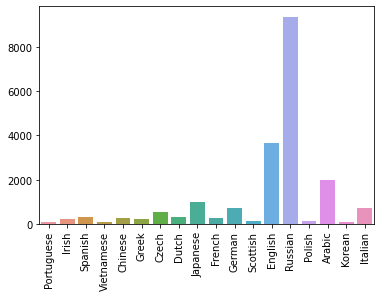

In [18]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Model Class

In [19]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [20]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
net = net.to(device_gpu)
print(net)

RNN_net(
  (rnn_cell): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [21]:
net.eval()
name_ohe = name_rep("Anubhav").to(device_gpu)
output, hidden = net(name_ohe)
print(output.shape)
print(hidden.shape)

torch.Size([1, 18])
torch.Size([1, 1, 128])


In [22]:
index = torch.argmax(hidden)

In [23]:
print(index)
print(output)
print(languages[torch.argmax(output).cpu().item()])

tensor(65, device='cuda:0')
tensor([[-2.9755, -2.8418, -2.8946, -3.0016, -2.8548, -2.8506, -2.9008, -3.0964,
         -2.7204, -2.9099, -2.8690, -2.9014, -2.9988, -2.8298, -2.9374, -2.8290,
         -2.8636, -2.8130]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
Japanese


In [24]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [25]:
print(languages[torch.argmax(infer(net, 'Anubhav', device_gpu)).cpu().item()])

Japanese


## Evaluate Model

In [26]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [27]:
data = dataloader(2, X_train, Y_train)

In [28]:
for name, lan, nam_rep, lan_rep in data:
  print("Name is : ", name, " and language is : ", lan)
  print(nam_rep.shape)
  print(lan_rep) 
  output = infer(net,name, device_gpu)
  val, indices = output.topk(5)
  index1, index2,index3, index4,index5 = indices[0][0].cpu().item(), indices[0][1].cpu().item(), indices[0][2].cpu().item(), indices[0][3].cpu().item(),indices[0][4].cpu().item()
  print("Top 5 predictions are : ")
  print("Predicted language is : ",languages[index1])
  print("Predicted language is : ",languages[index2])
  print("Predicted language is : ",languages[index3])
  print("Predicted language is : ",languages[index4])
  print("Predicted language is : ",languages[index5])
  print("==================\n")

Name is :  Merckx  and language is :  Dutch
torch.Size([6, 1, 57])
tensor([7])
Top 5 predictions are : 
Predicted language is :  Italian
Predicted language is :  Russian
Predicted language is :  Greek
Predicted language is :  Japanese
Predicted language is :  Czech

Name is :  Katznelson  and language is :  Russian
torch.Size([10, 1, 57])
tensor([13])
Top 5 predictions are : 
Predicted language is :  Japanese
Predicted language is :  Greek
Predicted language is :  Russian
Predicted language is :  Polish
Predicted language is :  Korean



In [29]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [30]:
print("Top 5 Precitions accuracy is : ",eval(net, 1000, 5, X_test, Y_test,device_gpu))
print("Top 4 Precitions accuracy is : ",eval(net, 1000, 4, X_test, Y_test,device_gpu))
print("Top 3 Precitions accuracy is : ",eval(net, 1000, 3, X_test, Y_test,device_gpu))
print("Top 2 Precitions accuracy is : ",eval(net, 1000, 5, X_test, Y_test,device_gpu))
print("Top 1 Precitions accuracy is : ",eval(net, 1000, 5, X_test, Y_test,device_gpu))

Top 5 Precitions accuracy is :  0.545
Top 4 Precitions accuracy is :  0.546
Top 3 Precitions accuracy is :  0.494
Top 2 Precitions accuracy is :  0.514
Top 1 Precitions accuracy is :  0.558


## Batching

In [31]:
names = ['Shyam', 'Ram', 'Anubhav']
max_word_size = 7
rep = torch.zeros(max_word_size, len(names), n_letters)
for name_index, name in enumerate(names):
  for letter_index, letter in enumerate(name):
    pos = all_letters.find(letter)
    rep[letter_index][name_index][pos] = 1

In [32]:
print(rep.shape)
print(rep[0]) #RSA

torch.Size([7, 3, 57])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [33]:
def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [34]:
out_ = batched_name_rep(['Shyam', 'Ram', 'Anubhav'], 7)
print(out_.shape)
print(out_[0].shape)

torch.Size([7, 3, 57])
torch.Size([3, 57])


In [35]:
print(rep.size()[-1])
x = rep.size()[-1]

57


In [36]:
rep.view((-1,x)).shape

torch.Size([21, 57])

In [37]:
name_reps = rep.view((-1,x))
for rows in name_reps:
  if torch.sum(rows) == 0:
    print('<pad>')
  else:
    index = rows.argmax()
    print(all_letters[index])

S
R
A
h
a
n
y
m
u
a
<pad>
b
m
<pad>
h
<pad>
<pad>
a
<pad>
<pad>
v


In [38]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [39]:
print_char(out_)

S
R
A
h
a
n
y
m
u
a
<pad>
b
m
<pad>
h
<pad>
<pad>
a
<pad>
<pad>
v


In [40]:
langs = languages[0:3]

In [41]:
rep = torch.zeros([len(langs)], dtype=torch.long)
print(rep.shape)

torch.Size([3])


In [42]:
for index, lang in enumerate(langs):
  print(languages.index(lang))
  rep[index] = languages.index(lang)
print(rep)

0
1
2
tensor([0, 1, 2])


In [43]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [44]:
langs = [languages[0], languages[15], languages[3] ]
batched_lang_rep(langs)

tensor([ 0, 15,  3])

In [45]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [46]:
padded_names, langs_rep = batched_dataloader(2, X_train, Y_train, True,device_gpu)

torch.Size([8, 2, 57]) torch.Size([12, 57])
--
['Riha', 'Vanichev']
R
V
i
a
h
n
a
i
<pad>
c
<pad>
h
<pad>
e
<pad>
v
--
V
R
a
i
n
h
i
a
c
h
e
v
Lang Rep tensor([ 6, 13], device='cuda:0')
Batch sizes tensor([2, 2, 2, 2, 1, 1, 1, 1])


## Training

In [47]:
def train(net, opt, criterion, n_points,device = 'cpu'):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, Y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1].to(device), hidden.to(device))
            
        loss = criterion(output, lang_rep.to(device))
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [48]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, Y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [49]:
net = RNN_net(n_letters, n_hidden, n_languages)
net = net.to(device_gpu)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [50]:
%%time 
train(net, opt, criterion, 256, device_gpu)

CPU times: user 1.28 s, sys: 45.5 ms, total: 1.32 s
Wall time: 1.34 s


tensor(2.9481, device='cuda:0', grad_fn=<DivBackward0>)

In [51]:
%%time 
train_batch(net, opt, criterion, 256,device_gpu)

CPU times: user 24.4 ms, sys: 36 µs, total: 24.4 ms
Wall time: 24.6 ms


tensor(1.8718, device='cuda:0', grad_fn=<NllLossBackward>)

## Full Training Step

In [52]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-5:', eval(net, len(X_test), 5, X_test, Y_test, device)) 
    print('Top-4:', eval(net, len(X_test), 4, X_test, Y_test, device))
    print('Top-3:', eval(net, len(X_test), 3, X_test, Y_test, device)) 
    print('Top-2:', eval(net, len(X_test), 2, X_test, Y_test, device))
    print('Top-1:', eval(net, len(X_test), 1, X_test, Y_test, device))                       

Iteration 4999 Loss 0.46946752071380615


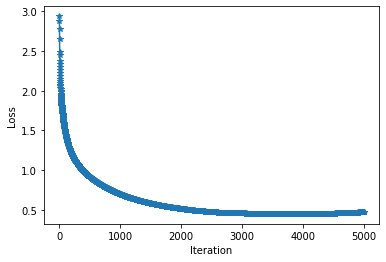




Top-5: 0.9526184538653366
Top-4: 0.9371571072319203
Top-3: 0.9032418952618454
Top-2: 0.8483790523690773
Top-1: 0.7596009975062344
CPU times: user 5min 26s, sys: 4.44 s, total: 5min 31s
Wall time: 5min 31s


In [53]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

Iteration 4999 Loss 0.44295328855514526


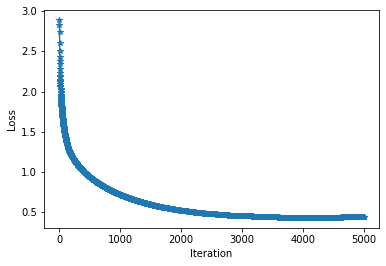




Top-5: 0.9528678304239402
Top-4: 0.9346633416458853
Top-3: 0.9037406483790523
Top-2: 0.8553615960099751
Top-1: 0.7446384039900249
CPU times: user 3min 57s, sys: 1.35 s, total: 3min 59s
Wall time: 3min 59s


In [54]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

In [55]:
data = dataloader(10, X_test, Y_test)
print("\n")
for name, lan, nam_rep, lan_rep in data:
  print("Name is : ", name, " and language is : ", lan, "(", lan_rep.item(),")")
  print(nam_rep.shape) 
  output = infer(net,name, device_gpu)
  val, indices = output.topk(5)
  print("Top 5 predictions are : ")
  for index in indices[0]:
    print("Predicted language is : ", languages[index.item()], "(",index.item(),")" )
  print("\n==================\n")



Name is :  Zhilenkov  and language is :  Russian ( 13 )
torch.Size([9, 1, 57])
Top 5 predictions are : 
Predicted language is :  Russian ( 13 )
Predicted language is :  Vietnamese ( 3 )
Predicted language is :  Korean ( 16 )
Predicted language is :  German ( 10 )
Predicted language is :  Chinese ( 4 )


Name is :  Chehovsky  and language is :  Russian ( 13 )
torch.Size([9, 1, 57])
Top 5 predictions are : 
Predicted language is :  Russian ( 13 )
Predicted language is :  Czech ( 6 )
Predicted language is :  German ( 10 )
Predicted language is :  English ( 12 )
Predicted language is :  Polish ( 14 )


Name is :  Bahr  and language is :  German ( 10 )
torch.Size([4, 1, 57])
Top 5 predictions are : 
Predicted language is :  German ( 10 )
Predicted language is :  Russian ( 13 )
Predicted language is :  English ( 12 )
Predicted language is :  Arabic ( 15 )
Predicted language is :  Irish ( 1 )


Name is :  Arato  and language is :  Japanese ( 8 )
torch.Size([5, 1, 57])
Top 5 predictions are 